In [1]:
# Dependencies and Setup
from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import re
import time 
import datetime 
import numpy as np
from config1 import username1,password1,host1,port1,database1,census_key
import sqlalchemy
from sqlalchemy import create_engine, func, inspect, desc
pd.options.mode.chained_assignment = None  # default='warn'
import requests
import json
from pandas.io.json import json_normalize
from timeit import default_timer as timer
from census import Census
from us import states
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import statistics
import math

Using TensorFlow backend.


In [2]:
# Database Setup
start = timer()
connection1=f'{username1}:{password1}@{host1}:{port1}/{database1}'
engine1 = create_engine(f'postgresql://{connection1}')

# Pull Data
state_heatmap=pd.read_sql_query('select * from state_heatmap', con=engine1)
county_heatmap=pd.read_sql_query('select * from county_heatmap', con=engine1)
state_cases=pd.read_sql_query('select * from state_cases', con=engine1)
state_deaths=pd.read_sql_query('select * from state_deaths', con=engine1)
county_cases1=pd.read_sql_query('select * from county_cases1', con=engine1)
county_cases2=pd.read_sql_query('select * from county_cases2', con=engine1)
county_cases3=pd.read_sql_query('select * from county_cases3', con=engine1)
county_deaths1=pd.read_sql_query('select * from county_deaths1', con=engine1)
county_deaths2=pd.read_sql_query('select * from county_deaths2', con=engine1)
county_deaths3=pd.read_sql_query('select * from county_deaths3', con=engine1)

# Concats
county_cases=pd.concat([county_cases1,county_cases2,county_cases3], ignore_index=True)
county_deaths=pd.concat([county_deaths1,county_deaths2,county_deaths3], ignore_index=True)
end = timer()
print(end - start)

12.254906100000001


In [3]:
# Call Cencus Data
start = timer()
c = Census(census_key, year=2018)
census_data = c.acs5.get(('B01003_001E', 'B17001_002E'), {'for': 'county:*'})

# Convert to DataFrame
census_df = pd.DataFrame(census_data)

# Column Reordering
census_df= census_df.rename(columns={'B01003_001E': 'Population',
                                      'B17001_002E': 'Poverty Count',
                                      'state':'State',
                                     'county':'County'})


census_df['fips']=census_df['State']+census_df['County']
state_census=census_df.groupby("State")["Population",'Poverty Count'].sum()
state_census=state_census.reset_index()
state_census=state_census.rename(columns={'State':'fips'})
end = timer()
print(end - start)

2.889087400000001


C:\Users\Henry Randall\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [4]:
start = timer()
state_area={}
with open('stateborders.json') as json_file:
    data = json.load(json_file)
data=data['features']
k=0
for state in data:
    state_area[k] = {"state":data[k]['properties']['NAME'],"fips": data[k]['properties']['STATE'],
                     "area": data[k]['properties']['CENSUSAREA']}
    k=k+1
state_area = pd.DataFrame.from_dict(state_area, "index")

county_area={}
with open('countyborders.json') as json_file:
    data = json.load(json_file)
data=data['features']
k=0
for county in data:
    county_area[k] = {"fips": (data[k]['properties']['STATE'])+(data[k]['properties']['COUNTY']),
                      "area": data[k]['properties']['CENSUSAREA']}
    k=k+1
county_area = pd.DataFrame.from_dict(county_area, "index")
end = timer()
print(end - start)

0.9507721999999994


In [5]:
start = timer()
state_census=state_census.merge(state_area, on='fips')
state_census.iloc[8,3]='District Of Columbia'
county_census=census_df.merge(county_area, on='fips')
county_census.iloc[291,1]=10300
state_census['Poverty Rate'] = 100 * \
    state_census['Poverty Count'].astype(
        int) / state_census['Population'].astype(int)
state_census['Population Density'] = 1 * \
    state_census['Population'].astype(
        int) / state_census['area'].astype(int)
state_census=state_census.drop(['Poverty Count','Population','area'], axis=1)
# Convert Poverty Copunt to Poverty Rate (Poverty Count / Population)
county_census['Poverty Rate'] = 100 * \
    county_census['Poverty Count'].astype(
        int) / county_census['Population'].astype(int)
county_census['Population Density'] = 1 * \
    county_census['Population'].astype(
        int) / county_census['area'].astype(int)
county_census=county_census.drop(['Poverty Count','Population','area','State','County'], axis=1)
end = timer()
print(end - start)

0.011291599999999846


In [6]:
county_heatmap=county_heatmap.merge(county_census,on='fips')
state_heatmap=state_heatmap.merge(state_census,on='state')

In [7]:
latdata_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
latdata=pd.read_csv(latdata_url, error_bad_lines=False)
latdata=latdata.rename(columns={'Province_State': 'State'})
latdata=latdata.reset_index()
latdata=latdata.drop(columns=['index'])
latdata.dropna(subset = ["Admin2"], inplace=True)
latdata=latdata[latdata.Admin2 != 'Unassigned']
latdata=latdata.dropna()
latdata=latdata[~latdata['Admin2'].astype(str).str.startswith('Out of')]
latdata=latdata[latdata.Admin2 != 'Out of*']
latdata=latdata.reset_index()
latdata['FIPS']=latdata.FIPS.map('{0:0>5.0f}'.format)
latdata=latdata[['State','FIPS','Lat','Long_']]
state_latdata=latdata.groupby('State').mean()
latdata=latdata.drop(columns=['State'])
state_latdata=state_latdata.reset_index()

In [8]:
#Find daily totals - county cases
start = timer()
county_cases_daily=county_cases.copy()
[r,c]=county_cases_daily.shape
for j in range (0,r):
    last=0
    for i in range (3,c):
        current=county_cases_daily.iloc[j,i]-last
        last=county_cases_daily.iloc[j,i]
        county_cases_daily.iat[j,i]=current
end = timer()
print(end - start)        

start = timer()
#Find daily totals - county deaths
county_deaths_daily=county_deaths.copy()
[r,c]=county_deaths_daily.shape
for j in range (0,r):
    last=0
    for i in range (3,c):
        current=county_deaths_daily.iloc[j,i]-last
        last=county_deaths_daily.iloc[j,i]
        county_deaths_daily.iat[j,i]=current
end = timer()
print(end - start)

9.623744099999996
9.969637499999997


In [9]:
#Find daily totals - state cases
start = timer()
state_cases_daily=state_cases.copy()
[r,c]=state_cases_daily.shape
for j in range (0,r):
    last=0
    for i in range (2,c):
        current=state_cases_daily.iloc[j,i]-last
        last=state_cases_daily.iloc[j,i]
        state_cases_daily.iat[j,i]=current
end = timer()
print(end - start)

#Find daily totals - state deaths
start = timer()
state_deaths_daily=state_deaths.copy()
[r,c]=state_deaths_daily.shape
for j in range (0,r):
    last=0
    for i in range (2,c):
        current=state_deaths_daily.iloc[j,i]-last
        last=state_deaths_daily.iloc[j,i]
        state_deaths_daily.iat[j,i]=current
end = timer()
print(end - start)

0.16332540000000506
0.1655350999999996


In [10]:
#Find 7day totals - county cases
start = timer()
county_cases_7day=county_cases_daily.copy()
[r,c]=county_cases_7day.shape
for j in range (0,r):
    for i in range (9,c):
        county_cases_7day.iloc[j,i]=statistics.mean([county_cases_daily.iloc[j,i-6],county_cases_daily.iloc[j,i-5],
                county_cases_daily.iloc[j,i-4],county_cases_daily.iloc[j,i-3],county_cases_daily.iloc[j,i-3],
                county_cases_daily.iloc[j,i-1],county_cases_daily.iloc[j,i]])
county_cases_7day = county_cases_7day.drop([county_cases_7day.columns[3],county_cases_7day.columns[4],
                                         county_cases_7day.columns[5],county_cases_7day.columns[6],
                                         county_cases_7day.columns[7],county_cases_7day.columns[8]],axis=1)
end = timer()
print(end - start)        

start = timer()
#Find 7day totals - county deaths
county_deaths_7day=county_deaths_daily.copy()
[r,c]=county_deaths_7day.shape
for j in range (0,r):
    last=0
    for i in range (9,c):
        county_deaths_7day.iloc[j,i]=statistics.mean([county_deaths_daily.iloc[j,i-6],county_deaths_daily.iloc[j,i-5],
                county_deaths_daily.iloc[j,i-4],county_deaths_daily.iloc[j,i-3],county_deaths_daily.iloc[j,i-3],
                county_deaths_daily.iloc[j,i-1],county_deaths_daily.iloc[j,i]])
county_deaths_7day = county_deaths_7day.drop([county_deaths_7day.columns[1],county_deaths_7day.columns[2],
                                         county_deaths_7day.columns[3],county_deaths_7day.columns[4],
                                         county_deaths_7day.columns[5],county_deaths_7day.columns[6]],axis=1)
end = timer()
print(end - start)

177.0308085
176.3043653


In [11]:
#Find 7day totals - state cases
start = timer()
state_cases_7day=state_cases_daily.copy()
[r,c]=state_cases_7day.shape
for j in range (0,r):
    for i in range (7,c):
        state_cases_7day.iloc[j,i]=statistics.mean([state_cases_daily.iloc[j,i-6],state_cases_daily.iloc[j,i-5],
                state_cases_daily.iloc[j,i-4],state_cases_daily.iloc[j,i-3],state_cases_daily.iloc[j,i-3],
                state_cases_daily.iloc[j,i-1],state_cases_daily.iloc[j,i]])
state_cases_7day = state_cases_7day.drop([state_cases_7day.columns[1],state_cases_7day.columns[2],
                                         state_cases_7day.columns[3],state_cases_7day.columns[4],
                                         state_cases_7day.columns[5],state_cases_7day.columns[6]],axis=1)
end = timer()
print(end - start)

start = timer()
#Find 7day totals - county deaths
state_deaths_7day=state_deaths_daily.copy()
[r,c]=state_deaths_7day.shape
for j in range (0,r):
    last=0
    for i in range (7,c):
        state_deaths_7day.iloc[j,i]=statistics.mean([state_deaths_daily.iloc[j,i-6],state_deaths_daily.iloc[j,i-5],
                state_deaths_daily.iloc[j,i-4],state_deaths_daily.iloc[j,i-3],state_deaths_daily.iloc[j,i-3],
                state_deaths_daily.iloc[j,i-1],state_deaths_daily.iloc[j,i]])
state_deaths_7day = state_deaths_7day.drop([state_deaths_7day.columns[1],state_deaths_7day.columns[2],
                                         state_deaths_7day.columns[3],state_deaths_7day.columns[4],
                                         state_deaths_7day.columns[5],state_deaths_7day.columns[6]],axis=1)
end = timer()
print(end - start)

2.7941308999999706
2.7158294000000183


In [12]:
# Proximity Cases - State
start = timer()
rad2_state_7day={}
rad5_state_7day={}
rad10_state_7day={}
[r,c]=state_cases_7day.shape
for j in range (0,r):
    lat=state_latdata.iloc[j,1]
    lon=state_latdata.iloc[j,2]
    index2=[]
    index5=[]
    index10=[]
    for k in range (0,r):
        dist=math.sqrt(((state_latdata.iloc[k,1]-lat)**2)+((state_latdata.iloc[k,2]-lon)**2))
        if dist<2:
            index2.append(k)
        if dist<5:
            index5.append(k)
        if dist<10:
            index10.append(k)
    rad2_state_7day[j]=((((state_cases_7day.iloc[index2,:]).sum())[1:])/(((state_heatmap.iloc[index2,:]).sum())['population']))*100000
    rad5_state_7day[j]=((((state_cases_7day.iloc[index5,:]).sum())[1:])/(((state_heatmap.iloc[index5,:]).sum())['population']))*100000
    rad10_state_7day[j]=((((state_cases_7day.iloc[index10,:]).sum())[1:])/(((state_heatmap.iloc[index10,:]).sum())['population']))*100000
rad2_state_7day = pd.DataFrame.from_dict(rad2_state_7day, "index")
rad2_state_7day.insert(0, 'State', state_cases_7day['State'])
rad5_state_7day = pd.DataFrame.from_dict(rad5_state_7day, "index")
rad5_state_7day.insert(0, 'State', state_cases_7day['State'])
rad10_state_7day = pd.DataFrame.from_dict(rad10_state_7day, "index")
rad10_state_7day.insert(0, 'State', state_cases_7day['State'])
end = timer()
print(end - start)

0.5625742999999943


In [13]:
# Proximity Cases - County
start = timer()
rad2_county_7day={}
rad5_county_7day={}
rad10_county_7day={}
[r,c]=county_cases_7day.shape
for j in range (0,r):
    lat=latdata.iloc[j,1]
    lon=latdata.iloc[j,2]
    index2=[]
    index5=[]
    index10=[]
    for k in range (0,r):
        dist=math.sqrt(((latdata.iloc[k,1]-lat)**2)+((latdata.iloc[k,2]-lon)**2))
        if dist<2:
            index2.append(k)
        if dist<5:
            index5.append(k)
        if dist<10:
            index10.append(k)
    rad2_county_7day[j]=((((county_cases_7day.iloc[index2,:]).sum())[3:])/(((county_heatmap.iloc[index2,:]).sum())['population']))*100000
    rad5_county_7day[j]=((((county_cases_7day.iloc[index5,:]).sum())[3:])/(((county_heatmap.iloc[index5,:]).sum())['population']))*100000
    rad10_county_7day[j]=((((county_cases_7day.iloc[index10,:]).sum())[3:])/(((county_heatmap.iloc[index10,:]).sum())['population']))*100000
rad2_county_7day = pd.DataFrame.from_dict(rad2_county_7day, "index")
rad2_county_7day.insert(0, 'FIPS', county_cases_7day['FIPS'])
rad2_county_7day.insert(1, 'County', county_cases_7day['County'])
rad2_county_7day.insert(2, 'State', county_cases_7day['State'])
rad5_county_7day = pd.DataFrame.from_dict(rad5_county_7day, "index")
rad5_county_7day.insert(0, 'FIPS', county_cases_7day['FIPS'])
rad5_county_7day.insert(1, 'County', county_cases_7day['County'])
rad5_county_7day.insert(2, 'State', county_cases_7day['State'])
rad10_county_7day = pd.DataFrame.from_dict(rad10_county_7day, "index")
rad10_county_7day.insert(0, 'FIPS', county_cases_7day['FIPS'])
rad10_county_7day.insert(1, 'County', county_cases_7day['County'])
rad10_county_7day.insert(2, 'State', county_cases_7day['State'])
end = timer()
print(end - start)

221.96999450000004


In [14]:
start = timer()
state_cases_popcorrected={}
k=0
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    pov=state_heatmap.iloc[j,13]
    popden=state_heatmap.iloc[j,14]
    for i in range (7,c-7):
        if state_cases.iloc[j,i+1]>0:
            state_cases_popcorrected[k] = {"pov": pov,"popden": popden,"day1": (state_cases.iloc[j,i]*100000)/pop,
"day2":(state_cases.iloc[j,i+1]*100000)/pop,"day3":(state_cases.iloc[j,i+2]*100000)/pop,
"day4":(state_cases.iloc[j,i+3]*100000)/pop,"day5":(state_cases.iloc[j,i+4]*100000)/pop,
"day6":(state_cases.iloc[j,i+5]*100000)/pop,"day7":(state_cases.iloc[j,i+6]*100000)/pop,                      
"rad27day1": (rad2_state_7day.iloc[j,i-6]),"rad27day2":(rad2_state_7day.iloc[j,i-5]),
"rad27day3":(rad2_state_7day.iloc[j,i-4]),"rad27day4":(rad2_state_7day.iloc[j,i-3]),
"rad27day5":(rad2_state_7day.iloc[j,i-2]),"rad27day6":(rad2_state_7day.iloc[j,i-1]),
"rad27day7":(rad2_state_7day.iloc[j,i]),"rad57day1": (rad5_state_7day.iloc[j,i-6]),
"rad57day2":(rad5_state_7day.iloc[j,i-5]),"rad57day3":(rad5_state_7day.iloc[j,i-4]),
"rad57day4":(rad5_state_7day.iloc[j,i-3]),"rad57day5":(rad5_state_7day.iloc[j,i-2]),
"rad57day6":(rad5_state_7day.iloc[j,i-1]),"rad57day7":(rad5_state_7day.iloc[j,i]),                                
"rad107day1": (rad10_state_7day.iloc[j,i-6]),"rad107day2":(rad10_state_7day.iloc[j,i-5]),
"rad107day3":(rad10_state_7day.iloc[j,i-4]),"rad107day4":(rad10_state_7day.iloc[j,i-3]),
"rad107day5":(rad10_state_7day.iloc[j,i-2]),"rad107day6":(rad10_state_7day.iloc[j,i-1]),
"rad107day7":(rad10_state_7day.iloc[j,i]),"7day1": (state_cases_7day.iloc[j,i-6]*100000)/pop,
"7day2":(state_cases_7day.iloc[j,i-5]*100000)/pop,"7day3":(state_cases_7day.iloc[j,i-4]*100000)/pop,
"7day4":(state_cases_7day.iloc[j,i-3]*100000)/pop,"7day5":(state_cases_7day.iloc[j,i-2]*100000)/pop,
"7day6":(state_cases_7day.iloc[j,i-1]*100000)/pop,"7day7":(state_cases_7day.iloc[j,i]*100000)/pop,
"7day8":(state_cases_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
state_cases_popcorrected = pd.DataFrame.from_dict(state_cases_popcorrected, "index")
end = timer()
print(end - start)

1.7242737999999918


In [15]:
start = timer()
state_deaths_popcorrected={}
k=0
[r,c]=state_deaths.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    pov=state_heatmap.iloc[j,13]
    popden=state_heatmap.iloc[j,14]
    for i in range (7,c-7):
        if state_deaths.iloc[j,i+1]>0:
            state_deaths_popcorrected[k] = {"pov":pov,"popden":popden,"casesday1":(state_cases.iloc[j,i]*100000)/pop,
"casesday2":(state_cases.iloc[j,i+1]*100000)/pop,"casesday3":(state_cases.iloc[j,i+2]*100000)/pop,
"casesday4":(state_cases.iloc[j,i+3]*100000)/pop,"casesday5":(state_cases.iloc[j,i+4]*100000)/pop,
"casesday6":(state_cases.iloc[j,i+5]*100000)/pop,"casesday7":(state_cases.iloc[j,i+6]*100000)/pop,
"7caseday1": (state_cases_7day.iloc[j,i-6]*100000)/pop,"7caseday2":(state_cases_7day.iloc[j,i-5]*100000)/pop,
"7caseday3":(state_cases_7day.iloc[j,i-4]*100000)/pop,"7caseday4":(state_cases_7day.iloc[j,i-3]*100000)/pop,
"7caseday5":(state_cases_7day.iloc[j,i-2]*100000)/pop,"7caseday6":(state_cases_7day.iloc[j,i-1]*100000)/pop,
"7caseday7":(state_cases_7day.iloc[j,i]*100000)/pop,"7caseday8":(state_cases_7day.iloc[j,i+1]*100000)/pop,
"day1":(state_deaths.iloc[j,i]*100000)/pop,"day2":(state_deaths.iloc[j,i+1]*100000)/pop,
"day3":(state_deaths.iloc[j,i+2]*100000)/pop,"day4":(state_deaths.iloc[j,i+3]*100000)/pop,
"day5":(state_deaths.iloc[j,i+4]*100000)/pop,"day6":(state_deaths.iloc[j,i+5]*100000)/pop,
"day7":(state_deaths.iloc[j,i+6]*100000)/pop,"7day1": (state_deaths_7day.iloc[j,i-6]*100000)/pop,
"7day2":(state_deaths_7day.iloc[j,i-5]*100000)/pop,"7day3":(state_deaths_7day.iloc[j,i-4]*100000)/pop,
"7day4":(state_deaths_7day.iloc[j,i-3]*100000)/pop,"7day5":(state_deaths_7day.iloc[j,i-2]*100000)/pop,
"7day6":(state_deaths_7day.iloc[j,i-1]*100000)/pop,"7day7":(state_deaths_7day.iloc[j,i]*100000)/pop,
"7day8":(state_deaths_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
state_deaths_popcorrected = pd.DataFrame.from_dict(state_deaths_popcorrected, "index")
end = timer()
print(end - start)

1.2937795999999935


In [16]:
start = timer()
county_cases_popcorrected={}
k=0
[r,c]=county_cases.shape
for j in range (0,r):
    pop=county_heatmap.iloc[j,9]
    pov=county_heatmap.iloc[j,11]
    popden=county_heatmap.iloc[j,12]
    for i in range (9,c-7):
        if county_cases.iloc[j,i+1]>0:
            county_cases_popcorrected[k] = {"pov":pov,"popden":popden,"day1":(county_cases.iloc[j,i]*100000)/pop,
"day2":(county_cases.iloc[j,i+1]*100000)/pop,"day3":(county_cases.iloc[j,i+2]*100000)/pop,
"day4":(county_cases.iloc[j,i+3]*100000)/pop,"day5":(county_cases.iloc[j,i+4]*100000)/pop,
"day6":(county_cases.iloc[j,i+5]*100000)/pop,"day7":(county_cases.iloc[j,i+6]*100000)/pop,
"rad27day1": (rad2_county_7day.iloc[j,i-6]),"rad27day2":(rad2_county_7day.iloc[j,i-5]),
"rad27day3":(rad2_county_7day.iloc[j,i-4]),"rad27day4":(rad2_county_7day.iloc[j,i-3]),
"rad27day5":(rad2_county_7day.iloc[j,i-2]),"rad27day6":(rad2_county_7day.iloc[j,i-1]),
"rad27day7":(rad2_county_7day.iloc[j,i]),"rad57day1": (rad5_county_7day.iloc[j,i-6]),
"rad57day2":(rad5_county_7day.iloc[j,i-5]),"rad57day3":(rad5_county_7day.iloc[j,i-4]),
"rad57day4":(rad5_county_7day.iloc[j,i-3]),"rad57day5":(rad5_county_7day.iloc[j,i-2]),
"rad57day6":(rad5_county_7day.iloc[j,i-1]),"rad57day7":(rad5_county_7day.iloc[j,i]),                                
"rad107day1": (rad10_county_7day.iloc[j,i-6]),"rad107day2":(rad10_county_7day.iloc[j,i-5]),
"rad107day3":(rad10_county_7day.iloc[j,i-4]),"rad107day4":(rad10_county_7day.iloc[j,i-3]),
"rad107day5":(rad10_county_7day.iloc[j,i-2]),"rad107day6":(rad10_county_7day.iloc[j,i-1]),
"rad107day7":(rad10_county_7day.iloc[j,i]),"7day1": (county_cases_7day.iloc[j,i-6]*100000)/pop,
"7day2":(county_cases_7day.iloc[j,i-5]*100000)/pop,"7day3":(county_cases_7day.iloc[j,i-4]*100000)/pop,
"7day4":(county_cases_7day.iloc[j,i-3]*100000)/pop,"7day5":(county_cases_7day.iloc[j,i-2]*100000)/pop,
"7day6":(county_cases_7day.iloc[j,i-1]*100000)/pop,"7day7":(county_cases_7day.iloc[j,i]*100000)/pop,
"7day8":(county_cases_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
county_cases_popcorrected = pd.DataFrame.from_dict(county_cases_popcorrected, "index")
cases_popcorrected=pd.concat([state_cases_popcorrected,county_cases_popcorrected])
end = timer()
print(end - start)

87.02632960000005


In [17]:
start = timer()
county_deaths_popcorrected={}
k=0
[r,c]=county_deaths.shape
for j in range (0,r):
    pop=county_heatmap.iloc[j,9]
    pov=county_heatmap.iloc[j,11]
    popden=county_heatmap.iloc[j,12]
    for i in range (9,c-7):
        if county_deaths.iloc[j,i+1]>0:
            county_deaths_popcorrected[k] = {"pov":pov,"popden":popden,"casesday1":(county_cases.iloc[j,i]*100000)/pop,
"casesday2":(county_cases.iloc[j,i+1]*100000)/pop,"casesday3":(county_cases.iloc[j,i+2]*100000)/pop,
"casesday4":(county_cases.iloc[j,i+3]*100000)/pop,"casesday5":(county_cases.iloc[j,i+4]*100000)/pop,
"casesday6":(county_cases.iloc[j,i+5]*100000)/pop,"casesday7":(county_cases.iloc[j,i+6]*100000)/pop,
"7caseday1": (county_cases_7day.iloc[j,i-6]*100000)/pop,"7caseday2":(county_cases_7day.iloc[j,i-5]*100000)/pop,
"7caseday3":(county_cases_7day.iloc[j,i-4]*100000)/pop,"7caseday4":(county_cases_7day.iloc[j,i-3]*100000)/pop,
"7caseday5":(county_cases_7day.iloc[j,i-2]*100000)/pop,"7caseday6":(county_cases_7day.iloc[j,i-1]*100000)/pop,
"7caseday7":(county_cases_7day.iloc[j,i]*100000)/pop,"7caseday8":(county_cases_7day.iloc[j,i+1]*100000)/pop,
"day1":(county_deaths.iloc[j,i]*100000)/pop,"day2":(county_deaths.iloc[j,i+1]*100000)/pop,
"day3":(county_deaths.iloc[j,i+2]*100000)/pop,"day4":(county_deaths.iloc[j,i+3]*100000)/pop,
"day5":(county_deaths.iloc[j,i+4]*100000)/pop,"day6":(county_deaths.iloc[j,i+5]*100000)/pop,
"day7":(county_deaths.iloc[j,i+6]*100000)/pop,"7day1": (county_deaths_7day.iloc[j,i-6]*100000)/pop,
"7day2":(county_deaths_7day.iloc[j,i-5]*100000)/pop,"7day3":(county_deaths_7day.iloc[j,i-4]*100000)/pop,
"7day4":(county_deaths_7day.iloc[j,i-3]*100000)/pop,"7day5":(county_deaths_7day.iloc[j,i-2]*100000)/pop,
"7day6":(county_deaths_7day.iloc[j,i-1]*100000)/pop,"7day7":(county_deaths_7day.iloc[j,i]*100000)/pop,
"7day8":(county_deaths_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
county_deaths_popcorrected = pd.DataFrame.from_dict(county_deaths_popcorrected, "index")
deaths_popcorrected=pd.concat([state_deaths_popcorrected,county_deaths_popcorrected])
end = timer()
print(end - start)

41.65492759999995


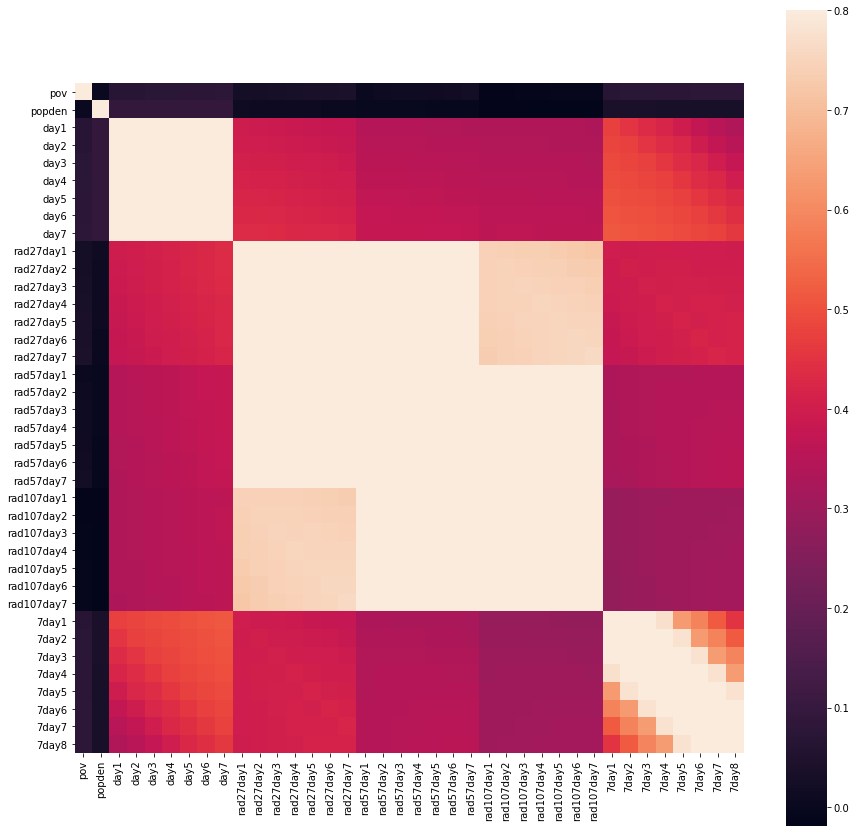

In [18]:
C_mat = cases_popcorrected.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

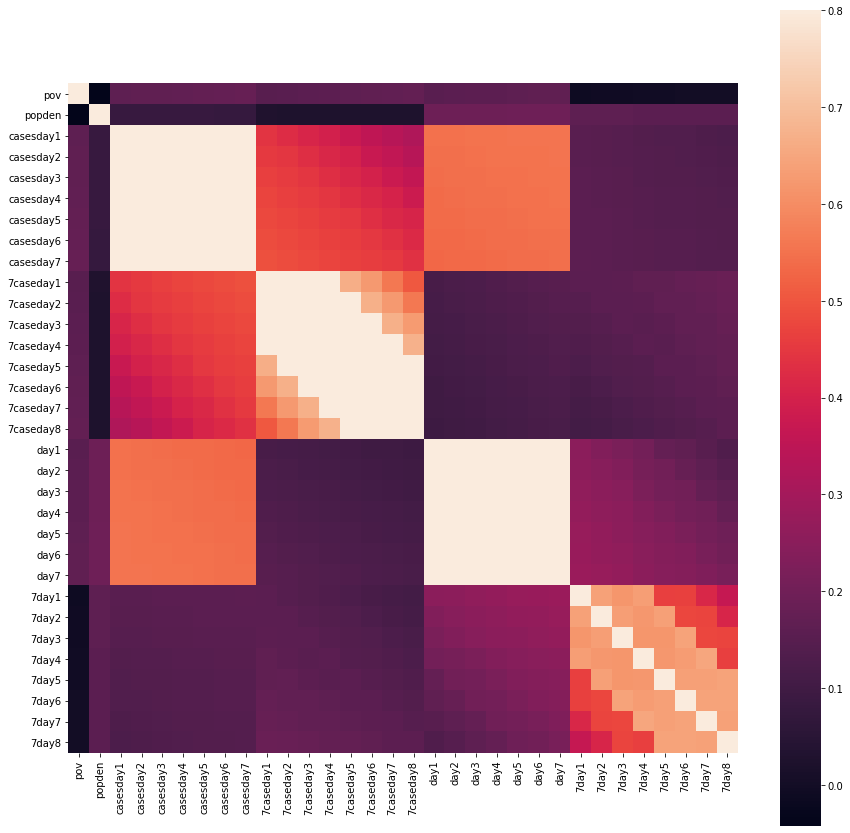

In [19]:
C_mat = deaths_popcorrected.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [20]:
x= cases_popcorrected[['pov','popden','day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7']]
y= cases_popcorrected['7day8'].values.reshape(-1, 1)
X = deaths_popcorrected[['pov','popden','casesday1', 'casesday2', 'casesday3', 'casesday4', 'casesday5', 'casesday6',
                         'casesday7','day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7']]
Y = deaths_popcorrected['7day8'].values.reshape(-1, 1)
print(X.shape, Y.shape, x.shape,y.shape)

(204455, 16) (204455, 1) (380111, 9) (380111, 1)


In [21]:
x= cases_popcorrected[['day1','day2','day3','day4','day5','day6','day7','rad27day1','rad27day2','rad27day3','rad27day4',
                       'rad27day5','rad27day6','rad27day7','7day1','7day2','7day3','7day4','7day5','7day6','7day7']]
y= cases_popcorrected['7day8'].values.reshape(-1, 1)
X = deaths_popcorrected[['popden','day5','day6','day7','7day1','7day2','7day3','7day4','7day5','7day6','7day7']]
Y = deaths_popcorrected['7day8'].values.reshape(-1, 1)
print(X.shape, Y.shape, x.shape,y.shape)

(204455, 11) (204455, 1) (380111, 21) (380111, 1)


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [23]:
model = Sequential()
model.add(Dense(33, kernel_initializer='normal',activation='relu', input_dim=X_train.shape[1]))
# Add a second hidden layer
model.add(Dense(66, kernel_initializer='normal',activation='relu'))
model.add(Dense(66, kernel_initializer='normal',activation='relu'))
model.add(Dense(66, kernel_initializer='normal',activation='relu'))
model.add(Dense(66, kernel_initializer='normal',activation='relu'))
model.add(Dense(66, kernel_initializer='normal',activation='relu'))
model.add(Dense(66, kernel_initializer='normal',activation='relu'))
# Y_train = to_categorical(Y_train)
# Add output layer
model.add(Dense(1,activation='linear'))
model.compile(loss="mean_squared_error",optimizer="Adamax", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 33)                396       
_________________________________________________________________
dense_1 (Dense)              (None, 66)                2244      
_________________________________________________________________
dense_2 (Dense)              (None, 66)                4422      
_________________________________________________________________
dense_3 (Dense)              (None, 66)                4422      
_________________________________________________________________
dense_4 (Dense)              (None, 66)                4422      
_________________________________________________________________
dense_5 (Dense)              (None, 66)                4422      
_________________________________________________________________
dense_6 (Dense)              (None, 66)                4

In [24]:
checkpoint_name = "models/model1"

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 0, 
                                                save_best_only = True, mode ='auto')
# Use the training data to fit (train) the model
model.fit(X_train,Y_train,epochs=500,shuffle=True,verbose=1,validation_split = 0.2,callbacks=[checkpoint])

Epoch 1/500
3797/3834 [============================>.] - ETA: 0s - loss: 0.2529 - accuracy: 0.8501 ETA: 0sWARNING:tensorflow:From C:\Users\Henry Randall\Anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models\model1\assets
3834/3834 [==============================] - 4s 1ms/step - loss: 0.2515 - accuracy: 0.8501 - val_loss: 0.2087 - val_accuracy: 0.8455
Epoch 2/500
3834/3834 [==============================] - 4s 935us/step - loss: 0.1863 - accuracy: 0.8454 - val_loss: 0.1895 - val_accuracy: 0.8441
Epoch 3/500
3834/3834 [==============================] - 3

Epoch 40/500
3834/3834 [==============================] - 2s 646us/step - loss: 0.1250 - accuracy: 0.8495 - val_loss: 0.1724 - val_accuracy: 0.8468
Epoch 41/500
3834/3834 [==============================] - 3s 654us/step - loss: 0.1227 - accuracy: 0.8498 - val_loss: 0.1812 - val_accuracy: 0.8474
Epoch 42/500
3834/3834 [==============================] - 3s 654us/step - loss: 0.1242 - accuracy: 0.8495 - val_loss: 0.1783 - val_accuracy: 0.8512
Epoch 43/500
3834/3834 [==============================] - 3s 689us/step - loss: 0.1263 - accuracy: 0.8499 - val_loss: 0.1636 - val_accuracy: 0.8466
Epoch 44/500
3834/3834 [==============================] - 3s 653us/step - loss: 0.1218 - accuracy: 0.8496 - val_loss: 0.1712 - val_accuracy: 0.8475
Epoch 45/500
3834/3834 [==============================] - 3s 653us/step - loss: 0.1233 - accuracy: 0.8497 - val_loss: 0.1858 - val_accuracy: 0.8495
Epoch 46/500
3834/3834 [==============================] - 3s 659us/step - loss: 0.1219 - accuracy: 0.8496 - val_

3834/3834 [==============================] - 3s 668us/step - loss: 0.1085 - accuracy: 0.8503 - val_loss: 0.2092 - val_accuracy: 0.8515
Epoch 96/500
3834/3834 [==============================] - 2s 650us/step - loss: 0.1083 - accuracy: 0.8502 - val_loss: 0.1821 - val_accuracy: 0.8511
Epoch 97/500
3834/3834 [==============================] - 3s 655us/step - loss: 0.1111 - accuracy: 0.8505 - val_loss: 0.1562 - val_accuracy: 0.8492
Epoch 98/500
3834/3834 [==============================] - 3s 665us/step - loss: 0.1081 - accuracy: 0.8503 - val_loss: 0.1599 - val_accuracy: 0.8500
Epoch 99/500
3834/3834 [==============================] - 2s 649us/step - loss: 0.1100 - accuracy: 0.8503 - val_loss: 0.1847 - val_accuracy: 0.8473
Epoch 100/500
3834/3834 [==============================] - 2s 645us/step - loss: 0.1076 - accuracy: 0.8501 - val_loss: 0.1587 - val_accuracy: 0.8480
Epoch 101/500
3834/3834 [==============================] - 3s 653us/step - loss: 0.1099 - accuracy: 0.8504 - val_loss: 0.159

3834/3834 [==============================] - 2s 652us/step - loss: 0.0989 - accuracy: 0.8506 - val_loss: 0.1881 - val_accuracy: 0.8488
Epoch 149/500
3834/3834 [==============================] - 3s 663us/step - loss: 0.0988 - accuracy: 0.8507 - val_loss: 0.1546 - val_accuracy: 0.8501
Epoch 150/500
3834/3834 [==============================] - 2s 651us/step - loss: 0.0983 - accuracy: 0.8509 - val_loss: 0.1517 - val_accuracy: 0.8505
Epoch 151/500
3834/3834 [==============================] - 3s 662us/step - loss: 0.0976 - accuracy: 0.8509 - val_loss: 0.1631 - val_accuracy: 0.8492
Epoch 152/500
3834/3834 [==============================] - 2s 647us/step - loss: 0.0990 - accuracy: 0.8508 - val_loss: 0.1441 - val_accuracy: 0.8490
Epoch 153/500
3834/3834 [==============================] - 3s 683us/step - loss: 0.0959 - accuracy: 0.8506 - val_loss: 0.1908 - val_accuracy: 0.8496
Epoch 154/500
3834/3834 [==============================] - 2s 644us/step - loss: 0.0968 - accuracy: 0.8507 - val_loss: 0

3834/3834 [==============================] - 2s 647us/step - loss: 0.0878 - accuracy: 0.8512 - val_loss: 0.1524 - val_accuracy: 0.8488
Epoch 202/500
3834/3834 [==============================] - 2s 651us/step - loss: 0.0877 - accuracy: 0.8508 - val_loss: 0.1566 - val_accuracy: 0.8481
Epoch 203/500
3834/3834 [==============================] - 2s 648us/step - loss: 0.0872 - accuracy: 0.8508 - val_loss: 0.1604 - val_accuracy: 0.8487
Epoch 204/500
3834/3834 [==============================] - 3s 654us/step - loss: 0.0873 - accuracy: 0.8507 - val_loss: 0.1658 - val_accuracy: 0.8489
Epoch 205/500
3834/3834 [==============================] - 3s 655us/step - loss: 0.0884 - accuracy: 0.8508 - val_loss: 0.1623 - val_accuracy: 0.8482
Epoch 206/500
3834/3834 [==============================] - 3s 660us/step - loss: 0.0851 - accuracy: 0.8509 - val_loss: 0.1446 - val_accuracy: 0.8487
Epoch 207/500
3834/3834 [==============================] - 3s 661us/step - loss: 0.0868 - accuracy: 0.8509 - val_loss: 0

3834/3834 [==============================] - 3s 658us/step - loss: 0.0792 - accuracy: 0.8509 - val_loss: 0.2186 - val_accuracy: 0.8497
Epoch 257/500
3834/3834 [==============================] - 3s 662us/step - loss: 0.0773 - accuracy: 0.8511 - val_loss: 0.1801 - val_accuracy: 0.8489
Epoch 258/500
3834/3834 [==============================] - 3s 653us/step - loss: 0.0806 - accuracy: 0.8509 - val_loss: 0.1603 - val_accuracy: 0.8498
Epoch 259/500
3834/3834 [==============================] - 3s 660us/step - loss: 0.0795 - accuracy: 0.8515 - val_loss: 0.1619 - val_accuracy: 0.8494
Epoch 260/500
3834/3834 [==============================] - 3s 656us/step - loss: 0.0773 - accuracy: 0.8514 - val_loss: 0.1797 - val_accuracy: 0.8501
Epoch 261/500
3834/3834 [==============================] - 2s 651us/step - loss: 0.0790 - accuracy: 0.8513 - val_loss: 0.1648 - val_accuracy: 0.8469
Epoch 262/500
3834/3834 [==============================] - 3s 659us/step - loss: 0.0790 - accuracy: 0.8510 - val_loss: 0

3834/3834 [==============================] - 3s 657us/step - loss: 0.0732 - accuracy: 0.8520 - val_loss: 0.1778 - val_accuracy: 0.8510
Epoch 312/500
3834/3834 [==============================] - 3s 663us/step - loss: 0.0733 - accuracy: 0.8522 - val_loss: 0.1958 - val_accuracy: 0.8498
Epoch 313/500
3834/3834 [==============================] - 3s 656us/step - loss: 0.0732 - accuracy: 0.8519 - val_loss: 0.1961 - val_accuracy: 0.8505
Epoch 314/500
3834/3834 [==============================] - 3s 654us/step - loss: 0.0717 - accuracy: 0.8521 - val_loss: 0.1686 - val_accuracy: 0.8504
Epoch 315/500
3834/3834 [==============================] - 3s 657us/step - loss: 0.0728 - accuracy: 0.8523 - val_loss: 0.1680 - val_accuracy: 0.8498
Epoch 316/500
3834/3834 [==============================] - 2s 649us/step - loss: 0.0710 - accuracy: 0.8521 - val_loss: 0.1780 - val_accuracy: 0.8491
Epoch 317/500
3834/3834 [==============================] - 2s 649us/step - loss: 0.0735 - accuracy: 0.8523 - val_loss: 0

3834/3834 [==============================] - 2s 646us/step - loss: 0.0696 - accuracy: 0.8520 - val_loss: 0.1966 - val_accuracy: 0.8503
Epoch 367/500
3834/3834 [==============================] - 2s 651us/step - loss: 0.0675 - accuracy: 0.8522 - val_loss: 0.1918 - val_accuracy: 0.8493
Epoch 368/500
3834/3834 [==============================] - 2s 641us/step - loss: 0.0696 - accuracy: 0.8517 - val_loss: 0.1984 - val_accuracy: 0.8486
Epoch 369/500
3834/3834 [==============================] - 2s 649us/step - loss: 0.0683 - accuracy: 0.8521 - val_loss: 0.2131 - val_accuracy: 0.8490
Epoch 370/500
3834/3834 [==============================] - 3s 654us/step - loss: 0.0677 - accuracy: 0.8518 - val_loss: 0.1752 - val_accuracy: 0.8491
Epoch 371/500
3834/3834 [==============================] - 2s 647us/step - loss: 0.0714 - accuracy: 0.8524 - val_loss: 0.1902 - val_accuracy: 0.8504
Epoch 372/500
3834/3834 [==============================] - 2s 646us/step - loss: 0.0683 - accuracy: 0.8523 - val_loss: 0

3834/3834 [==============================] - 3s 656us/step - loss: 0.0651 - accuracy: 0.8521 - val_loss: 0.1868 - val_accuracy: 0.8498
Epoch 422/500
3834/3834 [==============================] - 2s 651us/step - loss: 0.0628 - accuracy: 0.8525 - val_loss: 0.2261 - val_accuracy: 0.8460
Epoch 423/500
3834/3834 [==============================] - 2s 650us/step - loss: 0.0647 - accuracy: 0.8525 - val_loss: 0.2253 - val_accuracy: 0.8499
Epoch 424/500
3834/3834 [==============================] - 2s 646us/step - loss: 0.0662 - accuracy: 0.8523 - val_loss: 0.1898 - val_accuracy: 0.8499
Epoch 425/500
3834/3834 [==============================] - 2s 651us/step - loss: 0.0636 - accuracy: 0.8523 - val_loss: 0.1967 - val_accuracy: 0.8508
Epoch 426/500
3834/3834 [==============================] - 2s 639us/step - loss: 0.0657 - accuracy: 0.8523 - val_loss: 0.1974 - val_accuracy: 0.8496
Epoch 427/500
3834/3834 [==============================] - 2s 648us/step - loss: 0.0649 - accuracy: 0.8524 - val_loss: 0

3834/3834 [==============================] - 3s 654us/step - loss: 0.0608 - accuracy: 0.8531 - val_loss: 0.2151 - val_accuracy: 0.8508
Epoch 477/500
3834/3834 [==============================] - 3s 662us/step - loss: 0.0625 - accuracy: 0.8529 - val_loss: 0.2062 - val_accuracy: 0.8498
Epoch 478/500
3834/3834 [==============================] - 3s 658us/step - loss: 0.0638 - accuracy: 0.8528 - val_loss: 0.1867 - val_accuracy: 0.8512
Epoch 479/500
3834/3834 [==============================] - 3s 653us/step - loss: 0.0609 - accuracy: 0.8530 - val_loss: 0.1954 - val_accuracy: 0.8499
Epoch 480/500
3834/3834 [==============================] - 3s 660us/step - loss: 0.0609 - accuracy: 0.8531 - val_loss: 0.2171 - val_accuracy: 0.8515
Epoch 481/500
3834/3834 [==============================] - 3s 656us/step - loss: 0.0610 - accuracy: 0.8533 - val_loss: 0.1933 - val_accuracy: 0.8496
Epoch 482/500
3834/3834 [==============================] - 3s 658us/step - loss: 0.0610 - accuracy: 0.8530 - val_loss: 0

In [25]:
model2 = Sequential()
model2.add(Dense(63, kernel_initializer='normal',activation='relu', input_dim=x_train.shape[1]))
# Add a second hidden layer
model2.add(Dense(126, kernel_initializer='normal',activation='relu'))
model2.add(Dense(126, kernel_initializer='normal',activation='relu'))
model2.add(Dense(126, kernel_initializer='normal',activation='relu'))
model2.add(Dense(126, kernel_initializer='normal',activation='relu'))
model2.add(Dense(126, kernel_initializer='normal',activation='relu'))
model2.add(Dense(126, kernel_initializer='normal',activation='relu'))
# Y_train = to_categorical(Y_train)
# Add output layer
model2.add(Dense(1,activation='linear'))
model2.compile(loss="mean_squared_error",optimizer="Adamax", metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 63)                1386      
_________________________________________________________________
dense_9 (Dense)              (None, 126)               8064      
_________________________________________________________________
dense_10 (Dense)             (None, 126)               16002     
_________________________________________________________________
dense_11 (Dense)             (None, 126)               16002     
_________________________________________________________________
dense_12 (Dense)             (None, 126)               16002     
_________________________________________________________________
dense_13 (Dense)             (None, 126)               16002     
_________________________________________________________________
dense_14 (Dense)             (None, 126)              

In [26]:
checkpoint_name = "models/model2"

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 0, 
                                                save_best_only = True, mode ='auto')

# Use the training data to fit (train) the model
model2.fit(x_train,y_train,epochs=500,shuffle=True,verbose=1,validation_split = 0.2,callbacks=[checkpoint])

Epoch 1/500
7128/7128 [==============================] - 7s 988us/step - loss: 74.0152 - accuracy: 0.2251 - val_loss: 46.1095 - val_accuracy: 0.3145
Epoch 2/500
7128/7128 [==============================] - 7s 1ms/step - loss: 49.9317 - accuracy: 0.2650 - val_loss: 36.0259 - val_accuracy: 0.3023
Epoch 3/500
7128/7128 [==============================] - 7s 1ms/step - loss: 40.4318 - accuracy: 0.2689 - val_loss: 23.9749 - val_accuracy: 0.2948
Epoch 4/500
7128/7128 [==============================] - 7s 1ms/step - loss: 34.1624 - accuracy: 0.3077 - val_loss: 23.3188 - val_accuracy: 0.3035
Epoch 5/500
7128/7128 [==============================] - 6s 873us/step - loss: 31.8448 - accuracy: 0.3098 - val_loss: 51.4201 - val_accuracy: 0.1878
Epoch 6/500
7128/7128 [==============================] - 7s 1ms/step - loss: 31.4567 - accuracy: 0.3219 - val_loss: 19.8449 - val_accuracy: 0.3302
Epoch 7/500
7128/7128 [==============================] - 8s 1ms/step - loss: 28.7757 - accuracy: 0.3301 - val_loss

7128/7128 [==============================] - 6s 874us/step - loss: 22.3011 - accuracy: 0.3648 - val_loss: 12.8681 - val_accuracy: 0.3678
Epoch 42/500
7128/7128 [==============================] - 6s 881us/step - loss: 22.7082 - accuracy: 0.3620 - val_loss: 13.2331 - val_accuracy: 0.3837
Epoch 43/500
7128/7128 [==============================] - 6s 878us/step - loss: 22.1213 - accuracy: 0.3664 - val_loss: 13.8051 - val_accuracy: 0.3864
Epoch 44/500
7128/7128 [==============================] - 6s 880us/step - loss: 22.6458 - accuracy: 0.3683 - val_loss: 13.4885 - val_accuracy: 0.3736
Epoch 45/500
7128/7128 [==============================] - 6s 876us/step - loss: 22.2448 - accuracy: 0.3686 - val_loss: 13.4472 - val_accuracy: 0.3592
Epoch 46/500
7128/7128 [==============================] - 6s 869us/step - loss: 22.6459 - accuracy: 0.3699 - val_loss: 13.9040 - val_accuracy: 0.3720
Epoch 47/500
7128/7128 [==============================] - 6s 895us/step - loss: 23.2702 - accuracy: 0.3707 - val_

Epoch 93/500
7128/7128 [==============================] - 6s 872us/step - loss: 21.7662 - accuracy: 0.3759 - val_loss: 13.0531 - val_accuracy: 0.3540
Epoch 94/500
7128/7128 [==============================] - 6s 875us/step - loss: 21.0392 - accuracy: 0.3738 - val_loss: 12.9831 - val_accuracy: 0.3551
Epoch 95/500
7128/7128 [==============================] - 6s 880us/step - loss: 21.2184 - accuracy: 0.3746 - val_loss: 12.7970 - val_accuracy: 0.3857
Epoch 96/500
7128/7128 [==============================] - 6s 887us/step - loss: 21.6604 - accuracy: 0.3765 - val_loss: 15.2534 - val_accuracy: 0.3990
Epoch 97/500
7128/7128 [==============================] - 6s 866us/step - loss: 20.8423 - accuracy: 0.3728 - val_loss: 12.7158 - val_accuracy: 0.3786
Epoch 98/500
7128/7128 [==============================] - 6s 875us/step - loss: 21.5082 - accuracy: 0.3702 - val_loss: 13.0643 - val_accuracy: 0.3711
Epoch 99/500
7128/7128 [==============================] - 6s 872us/step - loss: 21.1270 - accuracy: 

7128/7128 [==============================] - 6s 874us/step - loss: 20.7528 - accuracy: 0.3800 - val_loss: 12.8725 - val_accuracy: 0.3862
Epoch 148/500
7128/7128 [==============================] - 6s 881us/step - loss: 20.5838 - accuracy: 0.3806 - val_loss: 13.1956 - val_accuracy: 0.3811
Epoch 149/500
7128/7128 [==============================] - 6s 880us/step - loss: 20.5840 - accuracy: 0.3774 - val_loss: 13.0364 - val_accuracy: 0.3847
Epoch 150/500
7128/7128 [==============================] - 6s 876us/step - loss: 20.3595 - accuracy: 0.3825 - val_loss: 13.2921 - val_accuracy: 0.3664
Epoch 151/500
7128/7128 [==============================] - 6s 874us/step - loss: 20.5462 - accuracy: 0.3805 - val_loss: 16.9518 - val_accuracy: 0.3742
Epoch 152/500
7128/7128 [==============================] - 6s 887us/step - loss: 20.9233 - accuracy: 0.3806 - val_loss: 15.5369 - val_accuracy: 0.3787
Epoch 153/500
7128/7128 [==============================] - 6s 872us/step - loss: 20.3613 - accuracy: 0.3812 

7128/7128 [==============================] - 6s 882us/step - loss: 20.4361 - accuracy: 0.3763 - val_loss: 15.7145 - val_accuracy: 0.3726
Epoch 202/500
7128/7128 [==============================] - 6s 876us/step - loss: 20.0818 - accuracy: 0.3769 - val_loss: 14.9107 - val_accuracy: 0.3755
Epoch 203/500
7128/7128 [==============================] - 6s 879us/step - loss: 20.0012 - accuracy: 0.3816 - val_loss: 13.1270 - val_accuracy: 0.3783
Epoch 204/500
7128/7128 [==============================] - 6s 867us/step - loss: 20.6025 - accuracy: 0.3811 - val_loss: 13.8559 - val_accuracy: 0.3721
Epoch 205/500
7128/7128 [==============================] - 6s 875us/step - loss: 19.9965 - accuracy: 0.3810 - val_loss: 13.4276 - val_accuracy: 0.3814
Epoch 206/500
7128/7128 [==============================] - 6s 874us/step - loss: 19.8305 - accuracy: 0.3793 - val_loss: 13.4220 - val_accuracy: 0.3620
Epoch 207/500
7128/7128 [==============================] - 6s 873us/step - loss: 20.0623 - accuracy: 0.3824 

7128/7128 [==============================] - 6s 869us/step - loss: 19.8093 - accuracy: 0.3830 - val_loss: 13.2603 - val_accuracy: 0.3679
Epoch 256/500
7128/7128 [==============================] - 6s 872us/step - loss: 19.8106 - accuracy: 0.3736 - val_loss: 13.6976 - val_accuracy: 0.3517
Epoch 257/500
7128/7128 [==============================] - 6s 889us/step - loss: 19.8364 - accuracy: 0.3774 - val_loss: 14.6146 - val_accuracy: 0.3650
Epoch 258/500
7128/7128 [==============================] - 6s 876us/step - loss: 19.6455 - accuracy: 0.3806 - val_loss: 15.2615 - val_accuracy: 0.3435
Epoch 259/500
7128/7128 [==============================] - 6s 881us/step - loss: 19.8814 - accuracy: 0.3790 - val_loss: 14.0546 - val_accuracy: 0.3857
Epoch 260/500
7128/7128 [==============================] - 6s 870us/step - loss: 19.7943 - accuracy: 0.3821 - val_loss: 13.2976 - val_accuracy: 0.3923
Epoch 261/500
7128/7128 [==============================] - 6s 896us/step - loss: 19.5155 - accuracy: 0.3820 

7128/7128 [==============================] - 6s 895us/step - loss: 19.3403 - accuracy: 0.3847 - val_loss: 14.1040 - val_accuracy: 0.3790
Epoch 310/500
7128/7128 [==============================] - 6s 881us/step - loss: 19.0015 - accuracy: 0.3835 - val_loss: 14.0732 - val_accuracy: 0.3810
Epoch 311/500
7128/7128 [==============================] - 6s 887us/step - loss: 19.4867 - accuracy: 0.3785 - val_loss: 15.6676 - val_accuracy: 0.3609
Epoch 312/500
7128/7128 [==============================] - 6s 890us/step - loss: 19.7254 - accuracy: 0.3835 - val_loss: 13.2353 - val_accuracy: 0.3843
Epoch 313/500
7128/7128 [==============================] - 6s 881us/step - loss: 19.2689 - accuracy: 0.3802 - val_loss: 14.0104 - val_accuracy: 0.3627
Epoch 314/500
7128/7128 [==============================] - 6s 879us/step - loss: 19.2434 - accuracy: 0.3809 - val_loss: 14.7480 - val_accuracy: 0.3834
Epoch 315/500
7128/7128 [==============================] - 6s 894us/step - loss: 19.3033 - accuracy: 0.3867 

7128/7128 [==============================] - 6s 878us/step - loss: 19.0826 - accuracy: 0.3854 - val_loss: 14.1923 - val_accuracy: 0.3934
Epoch 364/500
7128/7128 [==============================] - 6s 876us/step - loss: 18.9513 - accuracy: 0.3858 - val_loss: 13.6669 - val_accuracy: 0.3957
Epoch 365/500
7128/7128 [==============================] - 6s 884us/step - loss: 18.6798 - accuracy: 0.3862 - val_loss: 14.9857 - val_accuracy: 0.3959
Epoch 366/500
7128/7128 [==============================] - 6s 884us/step - loss: 19.0373 - accuracy: 0.3863 - val_loss: 13.4531 - val_accuracy: 0.3944
Epoch 367/500
7128/7128 [==============================] - 6s 870us/step - loss: 19.5117 - accuracy: 0.3831 - val_loss: 13.6066 - val_accuracy: 0.3800
Epoch 368/500
7128/7128 [==============================] - 6s 872us/step - loss: 18.7862 - accuracy: 0.3798 - val_loss: 13.6974 - val_accuracy: 0.3646
Epoch 369/500
7128/7128 [==============================] - 6s 887us/step - loss: 19.0559 - accuracy: 0.3839 

7128/7128 [==============================] - 6s 867us/step - loss: 18.7823 - accuracy: 0.3857 - val_loss: 14.5470 - val_accuracy: 0.3873
Epoch 418/500
7128/7128 [==============================] - 6s 867us/step - loss: 18.9010 - accuracy: 0.3834 - val_loss: 14.2905 - val_accuracy: 0.3901
Epoch 419/500
7128/7128 [==============================] - 6s 864us/step - loss: 18.3955 - accuracy: 0.3805 - val_loss: 14.2173 - val_accuracy: 0.3674
Epoch 420/500
7128/7128 [==============================] - 6s 868us/step - loss: 18.4370 - accuracy: 0.3834 - val_loss: 13.6345 - val_accuracy: 0.3750
Epoch 421/500
7128/7128 [==============================] - 6s 883us/step - loss: 18.7429 - accuracy: 0.3880 - val_loss: 13.7483 - val_accuracy: 0.3837
Epoch 422/500
7128/7128 [==============================] - 6s 868us/step - loss: 18.8466 - accuracy: 0.3882 - val_loss: 13.3968 - val_accuracy: 0.4000
Epoch 423/500
7128/7128 [==============================] - 6s 866us/step - loss: 18.7629 - accuracy: 0.3853 

7128/7128 [==============================] - 6s 864us/step - loss: 18.4359 - accuracy: 0.3852 - val_loss: 14.1709 - val_accuracy: 0.3940
Epoch 472/500
7128/7128 [==============================] - 6s 883us/step - loss: 18.4897 - accuracy: 0.3842 - val_loss: 13.5738 - val_accuracy: 0.3956
Epoch 473/500
7128/7128 [==============================] - 6s 859us/step - loss: 18.2355 - accuracy: 0.3858 - val_loss: 14.6484 - val_accuracy: 0.3811
Epoch 474/500
7128/7128 [==============================] - 6s 847us/step - loss: 18.8441 - accuracy: 0.3844 - val_loss: 15.3670 - val_accuracy: 0.3968
Epoch 475/500
7128/7128 [==============================] - 6s 868us/step - loss: 18.4698 - accuracy: 0.3829 - val_loss: 13.8726 - val_accuracy: 0.3908
Epoch 476/500
7128/7128 [==============================] - 6s 882us/step - loss: 18.4752 - accuracy: 0.3827 - val_loss: 13.7370 - val_accuracy: 0.3800
Epoch 477/500
7128/7128 [==============================] - 6s 868us/step - loss: 18.2698 - accuracy: 0.3852 

Multiple Linear Regression

In [27]:
# from sklearn.preprocessing import StandardScaler

# # Create a StandardScater model and fit it to the training data

# ### BEGIN SOLUTION
# X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)
# ### END SOLUTION

In [28]:
# # Transform the training and testing data using the X_scaler and y_scaler models

# ### BEGIN SOLUTION
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)
# y_train_scaled = y_scaler.transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)
# ### END SOLUTION

In [29]:
# Create a LinearRegression model and fit it to the scaled training data

### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)
### END SOLUTION

LinearRegression()

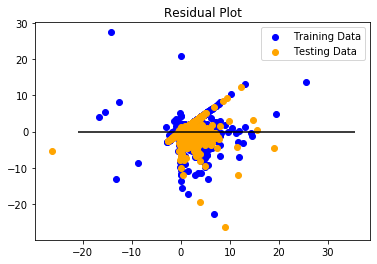

In [30]:
### BEGIN SOLUTION
import matplotlib.pyplot as plt
predictions = model.predict(X_test)
model.fit(X_train, Y_train)
plt.scatter(model.predict(X_train), model.predict(X_train) - Y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - Y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=Y_test.min(), xmax=Y_test.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [31]:
### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(Y_test, predictions)
r2 = model.score(X_test, Y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.1296157597528031, R2: 0.6047753732457466


In [32]:
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train,Y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(Y_test, predictions)
r2 = lasso.score(X_test, Y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.13632306261153787, R2: 0.5843234523224975


C:\Users\Henry Randall\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3618.0772938282425, tolerance: 4.510977062214414
  positive)


In [33]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, Y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(Y_test, predictions)
r2 = ridge.score(X_test, Y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.12961576234800976, R2: 0.6047753653324375


In [34]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, Y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(Y_test, predictions)
r2 = elasticnet.score(X_test, Y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.13309605623259924, R2: 0.5941632464500171


C:\Users\Henry Randall\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6453.513917290298, tolerance: 4.510977062214414
  positive)


In [35]:
print(f"Training Data Score: {model.score(X_train, Y_train)}")
print(f"Testing Data Score: {model.score(X_test, Y_test)}")

Training Data Score: 0.5703215010059912
Testing Data Score: 0.6047753732457466


In [36]:
#To retrieve the intercept:
print(model.intercept_)
#For retrieving the slope:
print(model.coef_)

[0.01032129]
[[ 5.69035226e-06  2.76916134e-02 -6.71143068e-02  3.96267527e-02
   6.95781171e-02 -5.15320030e-02 -5.47750671e-03 -1.80393622e-01
   3.35354373e-01  3.48086345e-01  2.93163437e-01]]


Optimizations and Testing

In [37]:
start = timer()
state_cases_processed=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
state_cases_popcorrected=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
cols=state_cases_processed.columns
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        temp=pd.DataFrame(state_cases.iloc[j,i:i+8]).T
        if temp.iloc[0,1]>0:
            pop_temp=(temp*100000)/pop
            new_cols = {x: y for x, y in zip(temp.columns, cols)}
            state_cases_processed = state_cases_processed.append(temp.rename(columns=new_cols))
            state_cases_popcorrected = state_cases_popcorrected.append(pop_temp.rename(columns=new_cols))
end = timer()
print(end - start)

23.752262500000143


In [38]:
start = timer()
# state_cases_processed=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
state_cases_popcorrected=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
cols=state_cases_popcorrected.columns
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        temp=pd.DataFrame(state_cases.iloc[j,i:i+8]).T
        if temp.iloc[0,1]>0:
            pop_temp=(temp*100000)/pop
            new_cols = {x: y for x, y in zip(temp.columns, cols)}
#             state_cases_processed = state_cases_processed.append(temp.rename(columns=new_cols))
            state_cases_popcorrected = state_cases_popcorrected.append(pop_temp.rename(columns=new_cols))
end = timer()
print(end - start)

17.4193765


In [39]:
start = timer()
# state_cases_processed=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
state_cases_popcorrected=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
cols=state_cases_popcorrected.columns
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        if state_cases.iloc[j,i+1]>0:
            temp=pd.DataFrame(state_cases.iloc[j,i:i+8]).T
            pop_temp=(temp*100000)/pop
            new_cols = {x: y for x, y in zip(temp.columns, cols)}
#             state_cases_processed = state_cases_processed.append(temp.rename(columns=new_cols))
            state_cases_popcorrected = state_cases_popcorrected.append(pop_temp.rename(columns=new_cols))
end = timer()
print(end - start)

14.918957699999737


In [40]:
state_cases.iloc[j,i]

2520

In [41]:
start = timer()
state_cases_popcorrected={}
k=0
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        if state_cases.iloc[j,i+1]>0:
            state_cases_popcorrected[k] = {"day1": (state_cases.iloc[j,i]*100000)/pop,"day2": (state_cases.iloc[j,i+1]*100000)/pop,"day3": (state_cases.iloc[j,i+2]*100000)/pop,"day4": (state_cases.iloc[j,i+3]*100000)/pop,"day5": (state_cases.iloc[j,i+4]*100000)/pop,"day6": (state_cases.iloc[j,i+5]*100000)/pop,"day7": (state_cases.iloc[j,i+6]*100000)/pop,"day8":(state_cases.iloc[j,i+7]*100000)/pop}
            k=k+1
state_cases_popcorrected = pd.DataFrame.from_dict(state_cases_popcorrected, "index")
end = timer()
print(end - start)

0.45681120000062947


In [42]:
state_cases_popcorrected

,day1,day2,day3,day4,day5,day6,day7,day8
0,0.000000,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803
1,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860
2,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733
3,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000
4,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000,3.997402
...,...,...,...,...,...,...,...,...
7625,405.522851,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455
7626,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794
7627,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484
7628,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484,485.176040


In [43]:
state_cases_popcorrected

,day1,day2,day3,day4,day5,day6,day7,day8
0,0.000000,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803
1,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860
2,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733
3,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000
4,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000,3.997402
...,...,...,...,...,...,...,...,...
7625,405.522851,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455
7626,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794
7627,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484
7628,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484,485.176040


In [44]:
cases_popcorrected

,pov,popden,day1,day2,day3,day4,day5,day6,day7,rad27day1,...,rad107day6,rad107day7,7day1,7day2,7day3,7day4,7day5,7day6,7day7,7day8
0,17.049426,96.054497,0.000000,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,0.000000,...,0.132113,0.158210,0.000000,0.000000,0.020395,0.000000,0.081580,0.101975,0.101975,0.244739
1,17.049426,96.054497,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,0.000000,...,0.158210,0.231606,0.000000,0.020395,0.000000,0.081580,0.101975,0.101975,0.244739,0.285529
2,17.049426,96.054497,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,0.020395,...,0.231606,0.361273,0.020395,0.000000,0.081580,0.101975,0.101975,0.244739,0.285529,0.305924
3,17.049426,96.054497,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,0.000000,...,0.361273,0.440378,0.000000,0.081580,0.101975,0.101975,0.244739,0.285529,0.305924,0.407898
4,17.049426,96.054497,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000,0.081580,...,0.440378,0.596141,0.081580,0.101975,0.101975,0.244739,0.285529,0.305924,0.407898,0.489478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372493,16.492958,2.960801,57.745056,57.745056,57.745056,57.745056,72.181319,72.181319,72.181319,3.274523,...,12.411708,11.706079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
372494,16.492958,2.960801,57.745056,57.745056,57.745056,72.181319,72.181319,72.181319,72.181319,3.929427,...,11.706079,10.926726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
372495,16.492958,2.960801,57.745056,57.745056,72.181319,72.181319,72.181319,72.181319,72.181319,2.947071,...,10.926726,11.190021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
372496,16.492958,2.960801,57.745056,72.181319,72.181319,72.181319,72.181319,72.181319,72.181319,3.929427,...,11.190021,10.458062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
deaths_popcorrected

,pov,popden,casesday1,casesday2,casesday3,casesday4,casesday5,casesday6,casesday7,7caseday1,...,day6,day7,7day1,7day2,7day3,7day4,7day5,7day6,7day7,7day8
0,17.049426,96.054497,4.935567,7.770459,10.544167,11.971810,14.154065,16.825798,18.335021,0.571057,...,0.203949,0.203949,0.0,0.000000,0.000000,0.000000,0.000000,0.020395,0.020395,0.040790
1,17.049426,96.054497,7.770459,10.544167,11.971810,14.154065,16.825798,18.335021,20.129773,0.917771,...,0.203949,0.469083,0.0,0.000000,0.000000,0.000000,0.020395,0.020395,0.040790,0.081580
2,17.049426,96.054497,10.544167,11.971810,14.154065,16.825798,18.335021,20.129773,21.618601,1.244089,...,0.469083,0.550662,0.0,0.000000,0.000000,0.020395,0.020395,0.040790,0.081580,0.040790
3,17.049426,96.054497,11.971810,14.154065,16.825798,18.335021,20.129773,21.618601,25.146920,1.121720,...,0.550662,0.652637,0.0,0.000000,0.020395,0.020395,0.040790,0.081580,0.040790,0.122369
4,17.049426,96.054497,14.154065,16.825798,18.335021,20.129773,21.618601,25.146920,30.490385,1.631593,...,0.652637,0.775006,0.0,0.020395,0.020395,0.040790,0.081580,0.040790,0.122369,0.101975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197613,11.274222,2.049831,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,0.000000,...,11.841326,11.841326,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
197614,11.274222,2.049831,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,0.000000,...,11.841326,11.841326,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
197615,11.274222,2.049831,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,0.000000,...,11.841326,11.841326,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
197616,11.274222,2.049831,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,0.000000,...,11.841326,11.841326,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
# # Outdated- categorical

# model2 = Sequential()
# model2.add(Dense(27, activation='relu', input_dim=x_train.shape[1]))
# # Add a second hidden layer
# model2.add(Dense(52, activation='relu'))
# model2.add(Dense(104, activation='relu'))
# model2.add(Dense(208, activation='relu'))
# model2.add(Dense(416, activation='relu'))
# model2.add(Dense(832, activation='relu'))
# model2.add(Dense(1664, activation='relu'))
# model2.add(Dense(3328, activation='relu'))
# model2.add(Dense(6656, activation='relu'))
# y_train = to_categorical(y_train)
# # Add output layer
# model2.add(Dense(y_train.shape[1], activation="softmax"))